### Project 4: Machine Learning to Excise RFI

This notebook is about simulating the response to a field-of-view with two point (delta-function) sources
in a time frequency spectograph, then use ML to excise RFI from the data.

### Table of Contents

1. **Overview of instrument (EVLA) Characteristics**
1. **Calculation of Dynamic Spectra**
1. **Calculation of RFI** 
1. **Implementation of ML algorithm**
1. **Evaluation of ML performance**
1. **Excising the RFI**
1. **Conclusion**

In [1]:
#import packages
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from astropy import units as u
from astropy import constants as const

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble
from sklearn import tree
# we can evaluate the model by getting the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# get the pickle package
import pickle
import itertools

import warnings
warnings.filterwarnings('always') 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

# Overview of instrument (EVLA) Characteristics

Lets import the data from EVLA website using the link: [antenna_positions_data](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/ant_positions.pdf)

NB: its worth noting that the data is in pdf format and we'll therefore
need convert it to a text file (or any file format) to make our life easier.

In [2]:
%%time
#create an empty array
data = []
#open the data and create an array of all line data
with open("data.txt") as f:
    for line in f:
        dataArray = line.split()
        data.append(dataArray)  

CPU times: user 714 µs, sys: 799 µs, total: 1.51 ms
Wall time: 891 µs


Lets try to manipulate the data in order use the EVLA by using the D-configuration as our interferometer

In [3]:
data
#lets first try to get the length of all the D-configurations positions
print("Length of all data:", len(data))
print("Length of the West Antennae:", len([elem[0] for elem in data if "W" in elem[0]]))
print("Length of the East Antennae:", len([elem[0] for elem in data if "E" in elem[0]]))
print("Length of the North Antennae:", len([elem[0] for elem in data if "N" in elem[0]]))

Length of all data: 73
Length of the West Antennae: 24
Length of the East Antennae: 24
Length of the North Antennae: 24


In [4]:
#lets split the data according to their positions i.e., North, East, West
#also note that we started at 1 since the 0th element in our list is ['\ufeff']
WAntennae = data[1:25]
EAntennae = data[25:49]
NAntennae = data[49:]

#we can now split the data according to their postions and save them in an array 
#by only considering those that have D-configuration 
arrayConfiguration = "D"
west = np.empty(0)

for i in WAntennae:
    if arrayConfiguration in i:
        west = np.append(west, i[-4:]) #get all the coordinates by slicing from -4 to end 
#reshape and flatten the array to get data per one receiver, i.e., Lx(ns), Ly(ns), Lx(nx) and R(m) 
west = np.reshape(np.ravel(west),(len(west)//4,4)).astype('float64')


east = np.empty(0)
for i in EAntennae:
    if arrayConfiguration in i:
        east = np.append(east, i[-4:]) #get all the coordinates by slicing from -4 to end 
#reshape and flatten the array to get data per one receiver, i.e., Lx(ns), Ly(ns), Lx(nx) and R(m) 
east = np.reshape(np.ravel(east),(len(east)//4,4)).astype('float64')

north = np.empty(0)
for i in NAntennae:
    if arrayConfiguration in i:
        north = np.append(north, i[-4:]) #get all the coordinates by slicing from -4 to end 
#reshape and flatten the array to get data per one receiver, i.e., Lx(ns), Ly(ns), Lx(nx) and R(m) 
north = np.reshape(np.ravel(north),(len(north)//4,4)).astype('float64')

Let's plot the antennae data that we got from the array of the VLA D-configuration

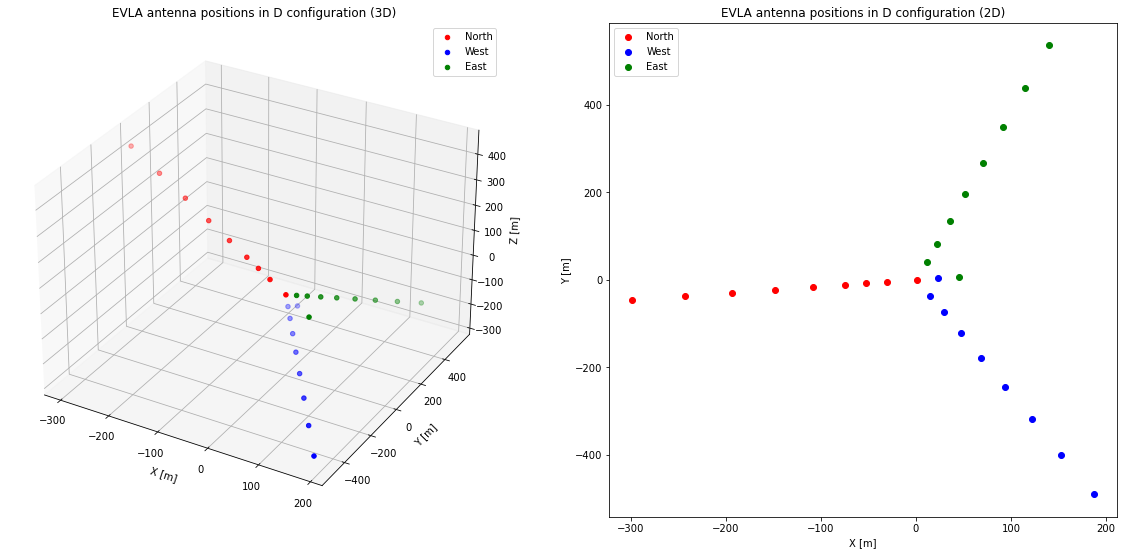

In [5]:
#attaching 3D axis to the figure
fig = plt.figure(figsize=(20,20))
# create a subplot of 2 figures with 1 row and 2 columns, 
# where the first figure will be a 3D plot and the second a 2D plot
ax1 = fig.add_subplot(2,2,1, projection='3d')

# setting the axes properties
ax1.set_xlabel('X [m]')
ax1.set_ylabel('Y [m]')
ax1.set_zlabel('Z [m]')
# set the title of the plot
ax1.set_title(f'EVLA antenna positions in {arrayConfiguration} configuration (3D)')


# #we need to calculate the distances between the satellites, nx, ny,nz given by the light travel time.
# #but we'll need to convert from ns to m by multiplying with the speed of light
nDistance = north[:, :3]*math.pow(10, -9)*const.c
wDistance = west[:, :3]*math.pow(10, -9)*const.c
eDistance = east[:, :3]*math.pow(10, -9)*const.c

# plot the data points in the 3D space
ax1.scatter(nDistance[:,0], nDistance[:,1], nDistance[:,2], c='r', marker='o', label='North')
ax1.scatter(wDistance[:,0], wDistance[:,1], wDistance[:,2], c='b', marker='o', label='West')
ax1.scatter(eDistance[:,0], eDistance[:,1], eDistance[:,2], c='g', marker='o', label='East')

# show the legend
ax1.legend()

# create the second figure
ax2 = fig.add_subplot(2,2,2)

# set the title of the plot
ax2.set_title(f'EVLA antenna positions in {arrayConfiguration} configuration (2D)')
# set the x and y labels
ax2.set_xlabel('X [m]')
ax2.set_ylabel('Y [m]')

# plot the data points in the 2D space
ax2.scatter(nDistance[:,0], nDistance[:,1], c='r', marker='o', label='North')
ax2.scatter(wDistance[:,0], wDistance[:,1], c='b', marker='o', label='West')
ax2.scatter(eDistance[:,0], eDistance[:,1], c='g', marker='o', label='East')

# show the legend
ax2.legend()

# show the plots
plt.show()


### 2. Calculations of Dynamic Spectra

We are given that the response to a field-of-view with two points (delta-function) sources, given below;


|Point Source|Position|Flux Density|
|:----:|:----:|:----:|
|Source 1|J 05 00 00 +45 00 00|3.6 Jy|
|Source 2|J 05 00 10 +45 03 00|5.8 Jy|

with Source 1 at the centre of the field of view.

Also, note that we only have one baseline when since we are having two point sources.

In this case we are going to use the spatial frequencies $u,v$ are just the distances expressed in wavelength units, so we can get the $u,v$ coordinates from the baseline length expressed in wavelength units from the following coordinate transformation: 

$$\begin{bmatrix} u \\ v \\ w \end{bmatrix} = \frac{1}{\lambda}\begin{bmatrix} \sin(h_o) & \cos(h_o) & 0 \\ -sin(\delta)\cos(h_o) & \sin(\delta)\sin(h_o) & \cos(\delta) \\ \cos(\delta)\cos(h_o) & -\cos(\delta)\sin(h_o) & \sin(\delta) \end{bmatrix} \begin{bmatrix} B_x \\ B_y \\ B_z \end{bmatrix}$$

where $B_x, B_y, Bz$ are baselines are differences of coordinates, i.e. for the baseline between two antennas,  $h_o$ is the hour angle (relative to the local meridian) and $\delta$ is the declination (relative to the celestial equator).


We are going to use the L-Band frequency of `2 GHz` as given on the [NRA website](https://science.nrao.edu/facilities/vla/observing/RFI/April-2021-D-configuration/L-Band_spectra_202104D). Since our test observation is only 3 hours long, which means it's less than the sidereal day we can treat it as a 2-D array since they're nearly coplanar and not only confined to an east-west line [VLA](https://www.cv.nrao.edu/~sransom/web/Ch3.html#S5). 

In [6]:
def single_baseline(ant1, ant2, frequency=2, dec_ang=45, HA=1.5):

    '''a function to define the baseline between two antennas
    Parameters
    ----------
    ant1: array of shape (3,)
        The position of the first antenna in the array
    ant2: array of shape (3,)
        The position of the second antenna in the array
    frequency: float
        The frequency of the observation in GHz
    dec_ang: float
        The declination angle of the observation in degrees
    HA: float
        The hour angle of the observation in hours
    Returns
    -------
   u, v: array 
        The baseline between the two antennas in the uv plane 
    '''
    #convert the hour angle to radians
    HA = HA*2*math.pi/24
    #convert the declination angle to radians
    dec_ang = dec_ang*math.pi/180
    #convert the frequency to hertz
    frequency = frequency*10**9
    #calculate the baseline
    baseline = ant2 - ant1
    # wavelength
    lam = frequency/const.c
    #calculate the baseline in uv coordinates
    baseline_length = np.array([[np.sin(HA), np.cos(HA), 0],
                                [-np.sin(dec_ang)*np.cos(HA), np.sin(dec_ang)*np.sin(HA), np.cos(dec_ang)],
                                [np.cos(dec_ang)*np.cos(HA), -np.cos(dec_ang)*np.sin(HA), np.sin(dec_ang)]])
        
    u = np.sum(baseline_length[0]*baseline[0]) * lam
    v = np.sum(baseline_length[1]*baseline[1]) * lam  
        
    return u, v

The function above will return the $u,v$ coordinates of the baselines in the form of a 2-D array.


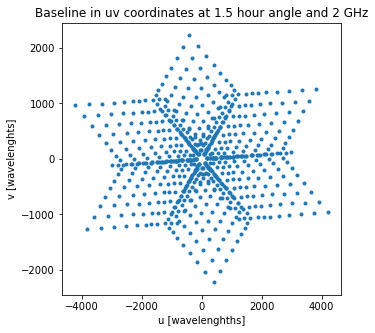

In [7]:
#create a  variable to store all the antannae spatial coordinates in meters i.e. x, y, z
north_m = nDistance[:,:3]
east_m = eDistance[:,:3]
west_m = wDistance[:,:3]
antennae = np.concatenate((north_m, east_m))
antennae = np.concatenate((antennae, west_m))

# create a 2D array of the baseline for the uv plane coordinates
baseline_uv = np.array([[0,0]])   #empty array
for i in range(antennae.shape[0]): #loop through all the north antennas
    for j in range(antennae.shape[0]): #loop through all the east antennas
        if i!=j:
            utemp, vtemp = single_baseline(antennae[i], antennae[j])
            temp = np.asarray([[utemp, vtemp]])
            baseline_uv = np.concatenate((baseline_uv, temp), axis=0)#append the baseline to the array
        

# plot the baseline in uv plane coordinates
plt.figure(figsize=(5,5))
plt.plot(baseline_uv[1:,0], baseline_uv[1:,1],'.')
plt.title("Baseline in uv coordinates at 1.5 hour angle and 2 GHz")
plt.xlabel("u [wavelenghths]")
plt.ylabel("v [wavelenghts]")
plt.show()

This is a uv snapashot at 45 $^{\circ}$. The lenght of $u, v$ from the origin represent the maximum distnace of an anatenna from the array center.

The table below summarises the VLA properties for the  D-Configuration; [resolution](https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/resolution) 

|D-Configuration Properties|||
|:----:|:----:|:----:|
$B_{max} (km^1)$||1.03|
|$B_{min} (km^1)$||0.035|
|**Band** | **Synthesized Beamwidth $\theta_{HPBW}(arcsec)^{1,2,3}$**|
|1.5 GHz (L)||46|
|**Band** | **Largest Angular Scale $\theta_{LAS}(arcsec)^{1,4}$**|
|1.5 GHz (L)||970


**Note:** These estimates of the synthesized beamwidth are for a uniformly weighted, untapered map produced from a full 12 hour synthesis observation of a source which passes near the zenith.

$B_{max}$ is the maximum antenna separation, $B_{min}$ is the minimum antenna separation, $\theta_{HPBW}$ is the synthesized beam width (FWHM), and $\theta_{LAS}$ is the largest angular scale structure visible to the array. 

In [8]:
s2_flux_den = 5.8 # source2 flux density in Jy
s2_dist = np.sqrt((10/(24*60*60) * 360*60*60)**2 + (3*60)**2) # source 2 offset distance  in arcsec


def clean_response(ant_No1, ant_No2, freq_samples=64, min_freq=1.5, max_freq=2, min_HA =-1.5, max_HA=1.5, sampling_H=60*3*2):
    '''
    This function calculates the clean response of the antenna No1 and No2
    Parameters
    ----------
    ant_No1: int
        The antenna number of the first antenna
    ant_No2: int
        The antenna number of the second antenna
    freq_samples: int
        The number of frequency samples
    min_freq: float
        The minimum frequency in GHz
    max_freq: float
        The maximum frequency in GHz
    min_HA: float
        The minimum hour angle in hours
    max_HA: float
        The maximum hour angle in hours
    sampling_H: float
        The sampling interval of the hour angle in hours
    '''
    
    
    antenna1 = antennae[ant_No1-1]
    antenna2 = antennae[ant_No2-1]

    # create an array of the source1 and source2
    source1 = np.asarray([0.,0.])
    source2 = np.asarray([2*np.pi*10/(24*60*60), 2*np.pi*3/(360*60)])
    # create a multidimensional meshgrid of the frequency and hour angle
    meshgrid = np.mgrid[min_freq:max_freq:freq_samples*1j,
                        min_HA:max_HA:sampling_H*1j]
    
    freq = meshgrid[0]
    HA = meshgrid[1]

    
    u, v = single_baseline(antenna1, antenna2, freq, HA)
    # calculate the response of the antenna from individual sources 
    response1 = 3.6*np.exp(-2j*np.pi*(u*source1[0] + v*source1[1]))
    response2 = 5.8*np.exp(-2j*np.pi*(u*source2[0] + v*source2[1]))
    response = response1 + response2

    return response
    

In [9]:
clean_response(21,9)

<Quantity [[-1.69093593+2.37613067j, -1.69107231+2.37582697j,
            -1.69120871+2.37552318j, ..., -1.74086286+2.26167722j,
            -1.7410058 +2.26133966j, -1.74114875+2.261002j  ],
           [-1.79807464+2.12150657j, -1.79819705+2.12119508j,
            -1.79831948+2.12088349j, ..., -1.84272356+2.00418567j,
            -1.84285089+2.00383985j, -1.84297824+2.00349393j],
           [-1.89296786+1.86206984j, -1.89307586+1.86175121j,
            -1.89318388+1.86143248j, ..., -1.93217836+1.74212587j,
            -1.93228963+1.74177252j, -1.93240089+1.74141906j],
           ...,
           [ 8.18881888-3.547216j  ,  8.18908819-3.54686758j,
             8.18935755-3.54651904j, ...,  8.28796312-3.41511373j,
             8.28824862-3.41472179j,  8.28853415-3.41432973j],
           [ 8.35251543-3.32469504j,  8.35276885-3.32433275j,
             8.35302232-3.32397034j, ...,  8.44562027-3.18746987j,
             8.4458878 -3.18706314j,  8.44615536-3.18665628j],
           [ 8.50543093-

We can now try to plot the frquency and time plot by choosing a baseline of our own.

Also note the responses were calculated using the formula on [field pattern of a 2D aperture](https://www.cv.nrao.edu/~sransom/web/Ch3.html) (Eq. 3.97)

$$f(l, m) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} g(u,v) \cdot e^{−i2\pi(lu+mv)}dudv$$


which can then be rewritten as a function of frequency and time as given below,

$$R_{ij}(f,t) = \sum_{K=1}^{2}g_k \cdot exp(-2i\pi \cdot (u_{ij}(f,t) \cdot x_k + v_{ij}(f,t) \cdot y_k))$$

**Note:** `ant_No1`, respresents the western antenna (from 19-27) while `ant_No2` (from 1-9) represents the northen antenna, this is clearly in the provided station positions on the VLA website.

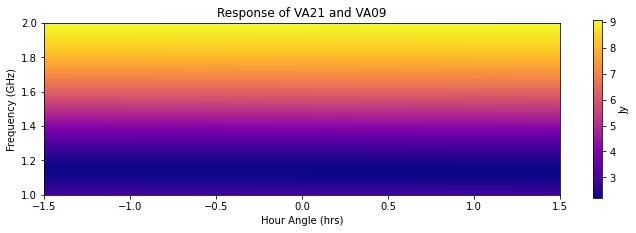

In [10]:
ant_No1 = 21
ant_No2 = 9

response = clean_response(ant_No1, ant_No2)
# print(response)


plt.figure(figsize=(10,10))
ant1 , ant2 = str(ant_No1), str(ant_No2)
# check value of antenna number if it is less than 10 then add a zero before the number
if ant_No1 < 10:
    ant1 = '0' + str(ant_No1)
if ant_No2 < 10:
    ant2 = '0' + str(ant_No2)

plt.title(f'Response of VA{ant1} and VA{ant2}') 
plt.xlabel('Hour Angle (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(np.abs(response),cmap='plasma',origin='lower',extent=[-1.5,1.5,1.0,2.0])
# cax = plt.axes([8.5, 09.15])
plt.colorbar(orientation='vertical',label='Jy',fraction=0.016,pad=0.06)
plt.show()

We will therefore need to calculate the interferometer noise which is given by the formula below taken from [NRAO website](https://www.cv.nrao.edu/~sransom/web/Ch3.html) (Eq. 3.203) 

$$\sigma_S= \frac{\sqrt{2}kT_s}{A_{e}[N(N−1)\Delta \nu \tau]^{1/2}}$$


But in the limit of large $N$, $[N(N-1)]^{1/2}\rightarrow N$ and the point-source sensitivity of an interferometer approaches that of a single antenna whose area equals the total effective area $NA_{e}$ of $N$ interferometer antennas. Therefore the above equation can be rewritten as


$$\sigma_S= \frac{\sqrt{2}kT_s}{A_{e}[N\Delta\nu\tau]^{1/2}}$$

$k = 1.38064852 \times 10^{-23} JK^{-1}$ is the Boltzmann constant,  $T_s = 33 K$ the system temperature, $A_{e} = \pi r^2 = \pi(12.5)^2 \eta_{c}$ the effective area of the telescope; where $\eta_{c}$ is the correlator efficiency (`~0.93` [with the use of the 8-bit samplers](https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/referencemanual-all-pages)), $\Delta\nu$ is the frequency bandwidth and lastly $\tau$ is the intergration time. 

In [11]:
def rms_noise(freq_samples=64, min_freq=1, max_freq=2, min_HA=-1.5, max_HA=1.5,sampling_H=60*3*2):
    '''
    This function calculates the rms noise of the antenna No1 and No3
    Parameters
    ----------
    ant_No1: int
        The antenna number of the first antenna
    ant_No3: int
        The antenna number of the third antenna
    freq_samples: int
        The number of frequency samples
    min_freq: float
        The minimum frequency in GHz
    max_freq: float
        The maximum frequency in GHz
    min_HA: float
        The minimum hour angle in hours
    max_HA: float
        The maximum hour angle in hours
    sampling_H: float
        The sampling interval of the hour angle in hours
    '''
    # constants
    k = 1.380649E-23  #[J/K]
    T_s = 33 #[K]
    eta_c = 0.93
    A = np.pi*(25**2)/4*eta_c #[m^2]
    N = 1
    tau = (max_HA-min_HA)*24*60*60/sampling_H
    # calculate the rms noise
    sigma = (np.sqrt(2)*k*T_s)/(A*np.sqrt(N*tau))
    # create a Gaussuian distribution noise array 
    noise = np.random.normal(0,sigma,(sampling_H,freq_samples))
    return noise.T

Lets visualize the random noise and the response with noise

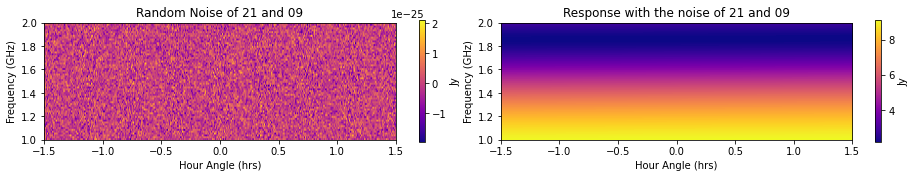

In [12]:
ant_No1, ant_No2 = 21, 9
# call noise  function and define a new array of noise
noise = rms_noise(freq_samples=64, min_freq=1, max_freq=2, min_HA=-1.5, max_HA=1.5,sampling_H=60*3*2)  # convert to Jy
noisy_response = clean_response(ant_No1, ant_No2) + noise

# plot two subplots of the random noise and the response with noise
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(noise, cmap='plasma', extent=[-1.5,1.5,1,2])
plt.title(f'Random Noise of {ant1} and {ant2}')
plt.xlabel('Hour Angle (hrs)')
plt.ylabel('Frequency (GHz)')
plt.colorbar(orientation='vertical',label='Jy',fraction=0.016, pad=0.06)   
plt.subplot(122)
plt.imshow(np.abs(noisy_response), cmap='plasma', extent=[-1.5,1.5,1,2])
plt.title(f'Response with the noise of {ant1} and {ant2}')
plt.xlabel('Hour Angle (hrs)')
plt.ylabel('Frequency (GHz)')
plt.colorbar(orientation='vertical',label='Jy', fraction=0.016, pad=0.06)
plt.show()

### 3. Calculation of RFI


We get  [RFI sources](https://science.nrao.edu/facilities/vla/observing/RFI/L-Band) for the L-Band from the website.

**Note:** The RFIs with lower and upper frequencies have been split into two separate columns,  `start_feq` and `end_freq`. 

We would save the RFI on the website in a CSV file and do basic data cleaning.

In [13]:
rfi_data = pd.read_csv('vla_RFI.csv')
rfi_data.head()

,Frequency,Description,Origin,Classification
0,1000,RATSCAT Low FQ,"NM, WSMR",Intermittent
1,1030,"Aeronautical IFF, gnd2air","OHD, Everywhere",Intermittent
2,1025-1150,Aircraft navigation DME,DME/VOR sites,intermittent
3,1090,"Aeronautical IFF, air2gnd","OHD, Everywhere",Intermittent
4,1166-1186,"GPS,Galileo,GLONASS L5","OHD, MEO",Continuous


In [14]:
# drop the Unnamed: 4 column
# rfi_data.drop(columns=['Unnamed: 4'], inplace=True)

# check for empty values in the dataframe
rfi_data.isnull().values.any()

# fill empty values with "NA"
rfi_data.fillna('NA',inplace=True)

# convert all the values in the classsificalion column to lower case
rfi_data['Classification'] = rfi_data['Classification'].str.lower()
# check if there is a hyphen in the frequency column then split the frequency column into two columns,
# start_freq and end_freq, in the case where there is no hyphen then the start_freq and end_freq will be the same
rfi_data['start_freq'] = rfi_data['Frequency'].str.split('-').str[0].astype(float)
rfi_data['end_freq'] = rfi_data['Frequency'].str.split('-').str[1].astype(float)

# fill the end_freq column with NA values with the start_freq column values
rfi_data['end_freq'].fillna(rfi_data['start_freq'], inplace=True)

# get a 2D array of the start_freq and end_freq columns
freq_range = rfi_data[['start_freq','end_freq']].values

In [15]:
# get column names with empty values
rfi_data.columns[rfi_data.isnull().any()]

Index([], dtype='object')

There are no longer columns with empty values. All the columns that had empty values, i.e., `Origin` and `Classification` columns have been filled with `NA`.


Now lets have a look at the header of our data after the modifications we have made.

In [16]:
rfi_data.head()

,Frequency,Description,Origin,Classification,start_freq,end_freq
0,1000,RATSCAT Low FQ,"NM, WSMR",intermittent,1000.0,1000.0
1,1030,"Aeronautical IFF, gnd2air","OHD, Everywhere",intermittent,1030.0,1030.0
2,1025-1150,Aircraft navigation DME,DME/VOR sites,intermittent,1025.0,1150.0
3,1090,"Aeronautical IFF, air2gnd","OHD, Everywhere",intermittent,1090.0,1090.0
4,1166-1186,"GPS,Galileo,GLONASS L5","OHD, MEO",continuous,1166.0,1186.0


In [17]:
# add an amplitude column calculated as the speed of light divided by the average of the start_freq and end_freq
mean_freq = (rfi_data['start_freq'] + rfi_data['end_freq'])/2
rfi_data['amplitude'] = const.c/(mean_freq*10**6)

# get an array of the amplitude column
amplitude = rfi_data['amplitude'].values
amplitude

array([0.29979246, 0.29106064, 0.27567123, 0.27503895, 0.25492556,
       0.24982705, 0.24512875, 0.24432963, 0.24353571, 0.24300075,
       0.24274693, 0.24041095, 0.23945085, 0.2389889 , 0.23751769,
       0.23642938, 0.2336652 , 0.23221724, 0.23149997, 0.2288492 ,
       0.22850035, 0.22763285, 0.22540786, 0.22418077, 0.22288739,
       0.22092296, 0.21962817, 0.21898646, 0.2170836 , 0.21645665,
       0.21521354, 0.21413747, 0.21292078, 0.2092792 , 0.20746883,
       0.20754064, 0.20696752, 0.20639756, 0.20625556, 0.205267  ,
       0.19966198, 0.19926385, 0.19781752, 0.19410324, 0.19652079,
       0.19600684, 0.19587877, 0.19150928, 0.19034442, 0.1890934 ,
       0.18667027, 0.18551513, 0.18477193, 0.18257762, 0.17908749,
       0.17791837, 0.17728708, 0.17624483, 0.17562534, 0.16927863,
       0.15614191])

In [18]:
rfi_data.head()

,Frequency,Description,Origin,Classification,start_freq,end_freq,amplitude
0,1000,RATSCAT Low FQ,"NM, WSMR",intermittent,1000.0,1000.0,0.299792
1,1030,"Aeronautical IFF, gnd2air","OHD, Everywhere",intermittent,1030.0,1030.0,0.291061
2,1025-1150,Aircraft navigation DME,DME/VOR sites,intermittent,1025.0,1150.0,0.275671
3,1090,"Aeronautical IFF, air2gnd","OHD, Everywhere",intermittent,1090.0,1090.0,0.275039
4,1166-1186,"GPS,Galileo,GLONASS L5","OHD, MEO",continuous,1166.0,1186.0,0.254926


In [19]:
# correct the classification values of 'pulsed & intermittant' to 'pulsed & intermittent'
rfi_data.loc[rfi_data['Classification'] == 'pulsed & intermittant','Classification'] = 'pulsed & intermittent'
# check unigue classifications in the dataframe
rfi_data['Classification'].unique()

array(['intermittent', 'continuous', 'pulsed & intermittent',
       'malfunction', 'na', 'sporadic'], dtype=object)

From the above code cell, we have six unique RFI classification classes namely; 

1. intermittent
2. continuous
3. pulsed & intermitted
4. malfunction
5. na
6. sporadic

In [20]:
# get unique values of the Classification column and store it in a list
classifications = rfi_data['Classification'].unique()
classifications

array(['intermittent', 'continuous', 'pulsed & intermittent',
       'malfunction', 'na', 'sporadic'], dtype=object)

In [21]:
# get unique values of the Description column and store it in a dictionary
descriptions = rfi_data['Description'].unique()
descriptions

array(['RATSCAT Low FQ', 'Aeronautical IFF, gnd2air',
       'Aircraft navigation DME', 'Aeronautical IFF, air2gnd',
       'GPS,Galileo,GLONASS L5', 'VLA modem', 'TARS Pulsed radar',
       'GPS L2', 'AEROSTAT', 'FAA ARSR4 radar', 'GLONASS L2',
       'TARS pulsed radar', 'COMPASS E6', 'FAA ASR radar',
       'WSMR RAJPO transponder', 'GPS L3 NUDET', 'internal birdie',
       'WSMR telemetry', 'High alt balloon', 'Test telemetry',
       'High alt baloon', 'WSMR jamming telemetry', 'INMARSAT satellites',
       'GPS L1 jamming', 'GPS L1', 'GLONASS L1', 'IRIDIUM satellites',
       '2nd harmonic VLA radios', 'RADIOSONDES- WX baloons',
       'GOES weather satellite', 'NOAA weather satellite',
       'PCS cell phone base stations'], dtype=object)

We have 32 unique RFI sources according to their descriptions and we have a total of 6 classes.

We can now generate the RFI by using the start and end bounds of frequency to determine at what position it appears in the time-frequency plot.
This will be achieved by differentiating each source of RFI based off of its `Classification`.

The RFI source listed as being `continuous` will included in all of the simulated data, 
RFI sources listed as `intermittent` will only appear in some of the simulated data, 
RFI sources listed as `pulsed & intermitted` will follow the same pattern as `intermittent`,
RFI sources listed as `malfunction` will be randomly placed in the time-frequency plot by randomly switching on and off,
RFI sources listed as `na` will be placed in the time-frequency plot at all times, and 
finaly RFI sources listed as `sporadic` will be scattered throughout at frequencies that they are listed at.

In [22]:
def calculate_RFI(classifications, amplitude, freq_samples=64, min_freq=1, max_freq=2, min_HA=-1.5, max_HA=1.5,sampling_H=60*3*2):
    '''
    This function calculates the RFI dataframe
    Parameters
    ----------
    classifications: list
        The list of classifications
    freq_samples: int
        The number of frequency samples
    min_freq: float
        The minimum frequency in GHz
    max_freq: float
        The maximum frequency in GHz
    min_HA: float
        The minimum hour angle in hours
    max_HA: float
        The maximum hour angle in hours
    sampling_H: float
        The sampling interval of the hour angle in hours
    '''
     # create a multidimensional meshgrid of the frequency and hour angle
    meshgrid = np.mgrid[min_freq:max_freq:freq_samples*1j,
                        min_HA:max_HA:sampling_H*1j]
    
    freq = meshgrid[0]
    HA = meshgrid[1]

    # create frequency and hour angle point size
    freq_point_size = (max_freq-min_freq)/freq_samples
    HA_point_size = (max_HA-min_HA)/sampling_H

    # create an empty RFI array which take the shape of the freq meshgrid
    RFI = np.zeros(freq.shape)    
    
    # create an empty RFI array which take the shape of the freq meshgrid
    RFI = np.zeros(freq.shape)
    
    classification = classifications
    amp = amplitude
   
   # loop through the classifications
    for i in range(len(classification)):
        # loop through the amplitudes
        for j in range(len(amp)):
            # check if the classification is continuous
            if classification[i] == 'continuous':
                # create an amplitude array of the classifications that are continuous
                amp_array = np.full(freq.shape, amp[j])
#                 print(amp_array)
                # get a 2D array of the start and end frequencies of the current classification
                freq_range = rfi_data[rfi_data['Classification'] == classification[i]][['start_freq','end_freq']].values *10**-3 # convert to GHz otherwise it will be THz
                # # get the RFI of the continuous classification by checking if the frequency is in the range of the current classification
                RFI += np.where((freq <= freq_range[0][0]-freq_point_size/2) &  (freq >= freq_range[0][1]-freq_point_size/2), RFI+amp_array, RFI)
                # print(freq_range)
                # RFI += np.where(np.logical_and(freq >= freq_range[j][0], freq <= freq_range[j][1], RFI), amp_array, RFI)    
                # print(RFI)      
            # check if the classification is intermittent
            elif classification[i] == 'intermittent':
                # get an array of the amplitude values with the same index as the frequency array
                amp_array = np.full(freq.shape, amp[j])
                # get a 2D array of the start and end frequencies of the current classification
                freq_range = rfi_data[rfi_data['Classification'] == classification[i]][['start_freq','end_freq']].values *10**-3
                # get the RFI of the intermittent classification by randomly selecting a frequency 
                # between the frequency range which they appear in
                RFI += np.where(np.random.rand(freq.shape[0], freq.shape[1]) < (freq_range[0][0]-freq_point_size/2)/(freq_range[0][1]-freq_point_size/2), RFI+amp_array, RFI)
            # check if the classification is pulsed and intermittent
            elif classification[i] == 'pulsed & intermittent':
                # get an array of the amplitude values with the same index as the frequency array
                amp_array = np.full(freq.shape, amp[j])
                # get a 2D array of the start and end frequencies of the current classification
                freq_range = rfi_data[rfi_data['Classification'] == classification[i]][['start_freq','end_freq']].values *10**-3
                # get the RFI of the pulsed and intermittent classification by randomly selecting a frequency 
                # between the frequency range which they appear in
                RFI += np.where(np.random.rand(freq.shape[0], freq.shape[1]) < (freq_range[0][0]-freq_point_size/2)/(freq_range[0][1]-freq_point_size/2), RFI+amp_array, RFI)
            # check if the classification is malfuntion
            elif classification[i] == 'malfunction':
                # get an array of the amplitude values with the same index as the frequency array
                amp_array = np.full(freq.shape, amp[j])
                # get a 2D array of the start and end frequencies of the current classification
                freq_range = rfi_data[rfi_data['Classification'] == classification[i]][['start_freq','end_freq']].values *10**-3
                # get the RFI of the malfunction classification by randomly switching the amplitude between 0 and 1 at the frequency range at which they appear
                RFI += np.where(np.random.rand(freq.shape[0], freq.shape[1]) < (freq_range[0][0]-freq_point_size/2)/(freq_range[0][1]-freq_point_size/2), RFI+amp_array, RFI)
            # check if the classification is na 
            elif classification[i] == 'na':
                # get an array of the amplitude values with the same index as the frequency array
                amp_array = np.full(freq.shape, amp[j])
                # get a 2D array of the start and end frequencies of the current classification
                freq_range = rfi_data[rfi_data['Classification'] == classification[i]][['start_freq','end_freq']].values *10**-3
                # get the RFI of the na classification along all the frequency range
                RFI += np.where(np.logical_and(freq >= freq_range[0][0], freq <= freq_range[0][1]), RFI+amp_array, RFI)
            # check if the classification is sporadic
            elif classification[i] == 'sporadic':
                # get an array of the amplitude values with the same index as the frequency array
                amp_array = np.full(freq.shape, amp[j])
                # get a 2D array of the start and end frequencies of the current classification
                freq_range = rfi_data[rfi_data['Classification'] == classification[i]][['start_freq','end_freq']].values *10**-3
                # get the RFI of the sporadic classification in the frequency range at which they scatteredly appear within the 
                # frequency range and amplitude 
                RFI += np.where(np.logical_and(freq >= freq_range[0][0], freq <= freq_range[0][1]), RFI+amp_array, RFI)

   
                

    return RFI
                

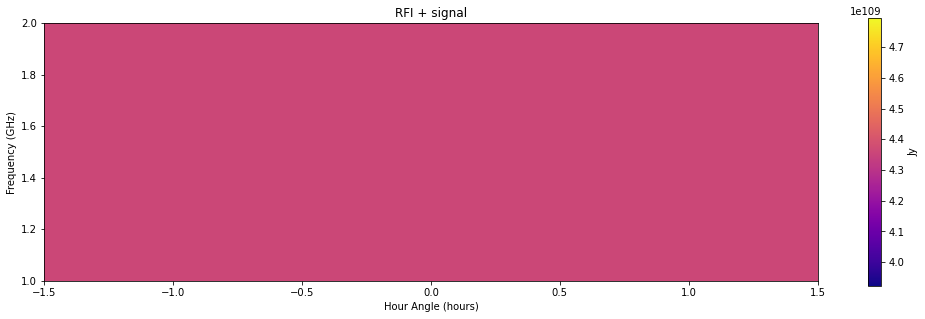

In [23]:
# Lets add RFI to the previously generated noise data
ant_No1, ant_No2 = 21, 9
# call noise  function and define a new array of noise
noise_RFI = rms_noise(freq_samples=64, min_freq=1, max_freq=2, min_HA=-1.5, max_HA=1.5,sampling_H=60*3*2) + calculate_RFI(classifications, amplitude)
noisy_response_RFI = noisy_response + calculate_RFI(classifications, amplitude)
# RFI += np.where((freq >= freq_range[0]) & (freq <= freq_range[-1]), amplitude_range*np.ones(freq.shape),0) 


# plot the RFI array together with the frequency and hour angle
plt.figure(figsize=(15,15))
plt.imshow(np.abs(noisy_response_RFI), cmap='plasma', extent=[-1.5,1.5,1,2])
plt.title("RFI + signal")
plt.ylabel('Frequency (GHz)')
plt.xlabel('Hour Angle (hours)')
plt.colorbar(orientation='vertical',label='Jy', fraction=0.016, pad=0.06)
plt.show()

That is the plot of the RFI and the signal together as a function of Frequency and Hour angle. If you look closely enough, you can see that it resembles the pattern of **Response with the noise of 21 and 03** plot. 

### 4. Implementation of ML algorithm

We can try to implement an ML algorithm that can be able to remove RFI from the dataset. But first we need to find a way to get features from our dataset that we can use to implement an ML algorithm for our dataset.

We'll map our `classifications` column to have the following;

|Feature No.| Feature Description | 
|-----------|---------------------|
|0|intermittent|
|1|continuous|
|2|pulsed & intermittent|
|3|malfuntion| 
|4|na |
|4|sporadic |




In [24]:
rfi_data.head()

,Frequency,Description,Origin,Classification,start_freq,end_freq,amplitude
0,1000,RATSCAT Low FQ,"NM, WSMR",intermittent,1000.0,1000.0,0.299792
1,1030,"Aeronautical IFF, gnd2air","OHD, Everywhere",intermittent,1030.0,1030.0,0.291061
2,1025-1150,Aircraft navigation DME,DME/VOR sites,intermittent,1025.0,1150.0,0.275671
3,1090,"Aeronautical IFF, air2gnd","OHD, Everywhere",intermittent,1090.0,1090.0,0.275039
4,1166-1186,"GPS,Galileo,GLONASS L5","OHD, MEO",continuous,1166.0,1186.0,0.254926


In [25]:
# get sources description
sources = rfi_data['Description'].unique()

In [26]:
def create_folds(rfi_data):

    # create a new kfold column based on the classification classes
    rfi_data.loc[:,'kfold'] = -1

    # randomize the dataframe
    rfi_data = rfi_data.sample(frac=1).reset_index(drop=True)

    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # fill the kfold column
    for k, (train_index, test_index) in enumerate(kf.split(rfi_data, rfi_data['Classification'])):
        rfi_data.loc[test_index, 'kfold'] = k
    

    # save the dataframe with the kfold column to a csv file
    rfi_data.to_csv('rfi_data_folds.csv', index=False)

We have now created a new kfold column which is based on the class of the RFI. We can now use this column to split our dataset into k folds.
But we'll need to create a new target column based on the class of the RFI which we can use to train our ML algorithm.

In [27]:
# read the csv file with the folds
df_kfold = pd.read_csv('rfi_data_folds.csv')
df_kfold.drop(['Unnamed: 0'], axis=1, inplace=True)
df_kfold.head()

,Frequency,Description,Origin,Classification,start_freq,end_freq,amplitude,kfold
0,1330,FAA ASR radar,"NM, Albuquerque",na,1330.00,1330.00,0.225408,0
1,1689-1693,GOES weather satellite,NaN,na,1689.00,1693.00,0.177078,0
2,1564-1586,GPS L1,OHD,continuous,1564.00,1586.00,0.189024,2
3,1235,AEROSTAT,NaN,malfunction,1235.00,1235.00,0.242747,0
4,1585.42,GPS L1 jamming,"NM, WSMR",continuous,1585.42,1585.42,0.189093,4


Using the kfold column to split our dataset into k folds won't  work out well since we a data 
imbalance even if we tried to v use the `StratifiedKFold` method and validate our ML algorithm.

In [28]:
def create_target(df_kfold):
    # create a new target column
    df_kfold.loc[:,'target'] = -1

    # fill the target column
    df_kfold.loc[df_kfold['Classification'].str.contains('intermittent'), 'target'] = 0
    df_kfold.loc[df_kfold['Classification'].str.contains('continuous'), 'target'] = 1
    df_kfold.loc[df_kfold['Classification'].str.contains('pulsed & intermittent'), 'target'] = 2
    df_kfold.loc[df_kfold['Classification'].str.contains('malfunction'), 'target'] = 3
    df_kfold.loc[df_kfold['Classification'].str.contains('na'), 'target'] = 4
    df_kfold.loc[df_kfold['Classification'].str.contains('sporadic'), 'target'] = 5

    # return the dataframe
    return df_kfold

In [29]:
create_target(df_kfold)

,Frequency,Description,Origin,Classification,start_freq,end_freq,amplitude,kfold,target
0,1330,FAA ASR radar,"NM, Albuquerque",na,1330.00,1330.00,0.225408,0,4
1,1689-1693,GOES weather satellite,NaN,na,1689.00,1693.00,0.177078,0,4
2,1564-1586,GPS L1,OHD,continuous,1564.00,1586.00,0.189024,2,1
3,1235,AEROSTAT,NaN,malfunction,1235.00,1235.00,0.242747,0,3
4,1585.42,GPS L1 jamming,"NM, WSMR",continuous,1585.42,1585.42,0.189093,4,1
...,...,...,...,...,...,...,...,...,...
56,1233.71,FAA ARSR4 radar,NaN,continuous,1233.71,1233.71,0.243001,4,1
57,1530.5,WSMR jamming telemetry,"NM, WSMR",intermittent,1530.50,1530.50,0.195879,3,0
58,1345.04,FAA ARSR4 radar,"NM, Eagle Peakk",continuous,1345.04,1345.04,0.222887,1,1
59,1705-1709,NOAA weather satellite,NaN,na,1705.00,1709.00,0.175420,4,4


In [30]:
new_df = pd.get_dummies(df_kfold, columns=["Description",	"Origin"], prefix=["desc", "orig"])
new_df.head()

,Frequency,Classification,start_freq,end_freq,amplitude,kfold,target,desc_2nd harmonic VLA radios,desc_AEROSTAT,"desc_Aeronautical IFF, air2gnd",...,"orig_NM, FT Bliss","orig_NM, FT Sumner","orig_NM, WSMR",orig_OHD,"orig_OHD, Everywhere","orig_OHD, MEO","orig_TX, FT Bliss",orig_VLA Site,orig_ea13,orig_numerous antennas
0,1330,na,1330.00,1330.00,0.225408,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1689-1693,na,1689.00,1693.00,0.177078,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1564-1586,continuous,1564.00,1586.00,0.189024,2,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1235,malfunction,1235.00,1235.00,0.242747,0,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1585.42,continuous,1585.42,1585.42,0.189093,4,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [31]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [32]:
# get the target column from the create_target function
new_df['target'] = new_df['target'].astype(int)

# get features and target
X = new_df.drop(['Frequency','Classification', 'kfold', 'target'], axis=1)
y = new_df['target']


train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 42)

# clf = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=3, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,seed=42)
clf = ensemble.GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=3, random_state=42)
clf.fit(train_features, train_labels)

clf.score(test_features, test_labels)

0.5625

Our model is only able to give an accuracy of `56%` which is not enough to remove the RFI.
We can try to use a different ML algorithm to remove the RFI. The problem with the low accuracy is that we 
do not have enough data to train our ML algorithm.

In [33]:
rf = ensemble.RandomForestClassifier()


n_estimators      = np.arange(50,1000,100)
max_features      = ['auto', 'sqrt', 'log2']
min_samples_split = np.arange(10,20,1)
max_depth         = np.arange(1,10,2)
class_weight      = ['balanced']
param_grid        = dict(n_estimators=n_estimators, max_features=max_features, \
                        min_samples_split=min_samples_split, class_weight=class_weight, max_depth=max_depth)
grid  = RandomizedSearchCV(rf, param_grid, n_iter=1 , cv=5 ,scoring = "balanced_accuracy",random_state=42)
grid.fit(train_features,train_labels)
opt_parameters = grid.best_params_
print(grid.best_params_)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


{'n_estimators': 650, 'min_samples_split': 12, 'max_features': 'log2', 'max_depth': 7, 'class_weight': 'balanced'}


In [34]:
grid.best_score_

0.7125

Using a `RandomizedSearchCV` approach, this gives a `72%` accuracy where the grid best parameters are given which we can use in our model. 
As from the above analysis, our model optimal for removing RFI is the `RandomizedSearchCV`.
is only able to give an accuracy of `72%` which is not really enough.

#### 6. Evaluation of ML Performance

We'll be need to evaluate the performance of our ML algorithm by trying different
ML algorithms and different parameters. While this might include the accuracy score
we can try to use the `f1_score` and `precision_score` and `recall_score` to evaluate the performance of our ML algorithm.

In [35]:
predcited_values = grid.predict(test_features)

In [36]:
print(classification_report(test_labels, predcited_values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.30      1.00      0.46         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       1.00      0.50      0.67         4

    accuracy                           0.56        16
   macro avg       0.46      0.50      0.43        16
weighted avg       0.56      0.56      0.50        16



/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The precision score is the fraction of the true positives that are predicted. In our case, we have 
some of the labels in test_features don't appear in y_pred. For the class 0, we got a precision of `0.8` 
which means that we predicted `80%` out of the `100%` of the class 0 labels. The same is can be used to explain the 
values of the remaining classes. 

For `recall_score` we have the fraction of the true positives that are predicted. In our case, we have `1.0` recall which 
means that we predicted all the class 0 labels. The same is can be used to explain the values of the remaining classes. The 
`f1-score` which is a metric that combines both `precision` and `recall` is the weighted average (harmonic mean) of the two.
For class 1, we got a `f1-score` of `0.89` which is a good score. However for class 2 and class 4, we gat an `f1-score` of `0.0` 
which means that we predicted no labels in those classes.  This might be due to the data imbalance.

In [37]:
# fit the model to the RandomizedSearchCV with the best parameters found by the grid.best_params_
fit_model = ensemble.RandomForestClassifier(**opt_parameters).fit(train_features,train_labels)

clf.score(test_features, test_labels)

0.5625

Normalized confusion matrix
[[1.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.5]]


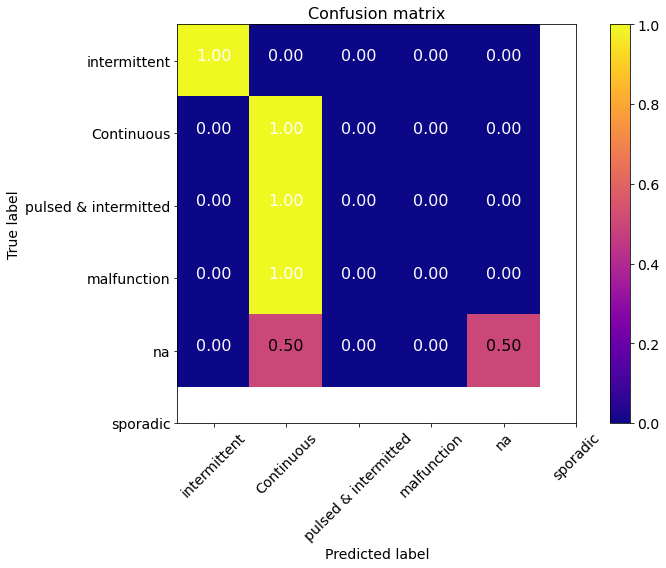

In [38]:
def plot_confusion_matrix(cm, classes_types, normalize=False, title='Confusion matrix', cmap=plt.cm.plasma):
    '''
    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.
    '''
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(10,8)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    cb=plt.colorbar(fraction=0.06, pad=0.06)
    cb.ax.tick_params(labelsize=14)
    tick_marks = np.arange(len(classes_types))
    plt.xticks(tick_marks, classes_types, rotation=45)
    plt.yticks(tick_marks, classes_types)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if (cm[i, j] < 0.01) or (cm[i,j] >= 0.75)  else "black",fontsize=16)
    plt.ylabel('True label',fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)
    plt.tight_layout()

classes=['intermittent', "Continuous","pulsed & intermitted","malfunction","na","sporadic"]
conf_mat = metrics.confusion_matrix(test_labels, predcited_values)
plot_confusion_matrix(conf_mat, classes,normalize=True, title='Confusion matrix',cmap=plt.cm.plasma)

From the confusion matrix, we can see that the accuracy is not high enough to remove the RFI.
There is a mismatch between the predicted class and the actual class. Most of the RFI is being predicted as `continuous` and the rest of the RFI is being predicted as `intermittent`.
This is because the ML algorithm is not able to distinguish between the two classes since the `continuous` class is the most common class.


The model can be improved by using a different ML algorithm. Hyperparameters can be used to tune the ML algorithm.
Finally, having a lot of data to train our ML algorithm can improve the accuracy of the model.

#### 5. References 


[1] NRAO. An introjuction to the NRAO Very Large Array. `https://science.nrao.edu/facilities/vla/docs/
manuals/oss2016A/ant_positions.pdf.` Accessed: 2021-11-27.

[2] Emmanuel Momjian and Tony Perreault. L-Band Spectra (1-2 GHz) 2021 April D-config. `https://science.
nrao.edu/facilities/vla/observing/RFI/April-2021-D-configuration/L-Band_spectra_202104D` Accessed: 2021-11-28.

[3] NRAO. 3.5 Radio Telescopes. `https://www.cv.nrao.edu/~sransom/web/Ch3.html#S5`, Accessed: 2021-
12-01.

[4] VLA SUS and Emmanuel Momjian. Resolution. `https://science.nrao.edu/facilities/vla/docs/manuals/
oss/performance/resolution`

[5] NRAO. Radio Telescopes and Radiometers. `https://www.cv.nrao.edu/~sransom/web/Ch3.html.`

[6] Emmanuel Momjian and Heidi Medlin. RFI at L-Band (1-2 GHz). `https://science.nrao.edu/facilities/
vla/observing/RFI/L-Band.`